# Convolutional Autoencoder

Yeah, I'm apparently actually doing this.

Structure is roughly as follows.

- Convolutional layer
- Symmetric(!!!) activation layer
- Max pooling layer
- Dropout layer
- Flatten layer
- Dense layer
- Symmetric activation layer
- Unflatten layer
- Unpool layer
- Deconvolutional layer
- Symmetric activation layer

Inspiration from https://github.com/mikesj-public/convolutional_autoencoder/blob/master/mnist_conv_autoencode.py and https://github.com/nanopony/keras-convautoencoder/blob/master/conv_autoencoder.py.

Let's load up the dataset I put up on Zenodo.

In [52]:
import h5py, numpy

with h5py.File('../data/dataset.h5', 'r') as f:
    features = f['features'][:, -32 * 32:]

Now we'll build an autoencoder...

In [53]:
import keras, \
        keras.layers, \
        keras.layers.core as core, \
        keras.layers.convolutional as conv, \
        keras.models as models
from keras import backend as K
from keras.engine.topology import Layer

n_filters = 32
conv_size = 5
pool_size = 2
dropout = 0.25
patch_size = 32
conv_out_size = (patch_size - conv_size) // pool_size + 1
hidden = n_filters * conv_out_size

In [54]:
class Sum(Layer):
    def __init__(self, **kwargs):
        super(Sum, self).__init__(**kwargs)

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return x.sum(axis=1)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],) + input_shape[2:]

In [83]:
model = models.Sequential()

# Encoder.
model.add(conv.Convolution2D(n_filters, conv_size, conv_size,
                             border_mode='valid',
                             input_shape=(1, patch_size, patch_size)))
model.add(core.Activation('tanh'))
model.add(conv.MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(core.Dropout(dropout))
model.add(core.Flatten())

# Dense.
# model.add(core.Dense(n_filters * conv_out_size * conv_out_size))
# model.add(core.Activation('tanh'))

# Decoder.
model.add(core.Reshape((n_filters, conv_out_size, conv_out_size)))
model.add(conv.UpSampling2D(size=(pool_size, pool_size)))
model.add(core.Activation('tanh'))
model.add(conv.ZeroPadding2D(padding=(conv_size - 1, conv_size - 1)))
deconv = conv.Convolution2D(n_filters, conv_size, conv_size,
                            border_mode='valid')
model.add(deconv)
model.add(Sum())

model.compile(loss='mse', optimizer='adadelta')

In [ ]:
images = features.reshape((-1, patch_size, patch_size))
model.fit(images[:100].reshape((-1, 1, patch_size, patch_size)), images[:100], nb_epoch=1000)

Epoch 1/1000
100/100 [==============================] - 4s - loss: 1.4367e-04     
Epoch 2/1000
100/100 [==============================] - 4s - loss: 1.4295e-04     
Epoch 3/1000
100/100 [==============================] - 5s - loss: 1.4476e-04     
Epoch 4/1000
100/100 [==============================] - 4s - loss: 1.4322e-04     
Epoch 5/1000
100/100 [==============================] - 4s - loss: 1.4539e-04     
Epoch 6/1000
100/100 [==============================] - 4s - loss: 1.4395e-04     
Epoch 7/1000
100/100 [==============================] - 5s - loss: 1.4723e-04     
Epoch 8/1000
100/100 [==============================] - 4s - loss: 1.4741e-04     
Epoch 9/1000
100/100 [==============================] - 4s - loss: 1.5063e-04     
Epoch 10/1000
100/100 [==============================] - 4s - loss: 1.5211e-04     
Epoch 11/1000
100/100 [==============================] - 4s - loss: 1.5046e-04     
Epoch 12/1000
100/100 [==============================] - 4s - loss: 1.5233e-04     
E

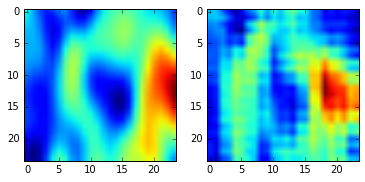

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

i = 100
plt.subplot(1, 2, 1)
plt.imshow(images[i, 4:-4, 4:-4])
plt.subplot(1, 2, 2)
plt.imshow(model.predict(images[i].reshape((-1, 1, 32, 32)))[0, 4:-4, 4:-4])
plt.show()